<a href="https://colab.research.google.com/github/kylemath/DeepEEG/blob/master/notebooks/DeepEEG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## DeepEEG

Goal is to make deep learning stacks that processes generally EEG trials as input and predicts binary trial category as output. This is all made to run on Google Colab notebooks using cloud GPU capabilities, so the git repo's get loaded at the start of the code into the workspace. Minor mods may be needed to use local Jupyter notebook. Long term goal of command line interface and mne toolbox plugin.

Strategy:
* Load in Brain Products files with mne, 
* normal pre-processing to get to trials
* Options for frequency or time domain
* Decimate time to reduce features
* Dataset example: P300 during biking outside? 

API:
* Input the data directory and subject numbers of any eeg-notebook experiment (https://github.com/kylemath/eeg-notebooks)
* Load in .vhdr brain products files
* FeatureEngineer can load any mne Epoch object - https://martinos.org/mne/stable/generated/mne.Epochs.html
* More general with the master eeg-notebooks - https://github.com/NeuroTechX/eeg-notebooks

LearningModels:
* First try basic Neural Network (NN)
* Then try Convolution Neural Net (CNN)
* Then try Long-Short Term Memory Recurrant Neural Net (LSTM, RNN)

DataModels:
* Try subject specific models 
* Then pool data over all subjects
* Then try multilevel models

Using: 
* https://github.com/kylemath/eeg-notebooks
* https://github.com/mne-tools/mne-python
* https://github.com/keras-team/keras/blob/master/examples/imdb_cnn_lstm.py
* https://github.com/ml4a/ml4a-guides/blob/master/notebooks/keras_classification.ipynb
* https://github.com/tevisgehr/EEG-Classification

Resources:
* https://arxiv.org/pdf/1901.05498.pdf 
* http://proceedings.mlr.press/v56/Thodoroff16.pdf
*  https://arxiv.org/abs/1511.06448
*  https://github.com/ml4a

#Connect to Google Drive

In [1]:
#mount google drive to load own images, follow link and get code and paste in below
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


#Install and Setup 

In [2]:
!pip install mne
from mne import pick_types, viz, io, Epochs 
from mne import channels, find_events, concatenate_raws
from mne import read_evokeds
from mne.time_frequency import tfr_morlet

import pandas as pd
pd.options.display.max_columns = None
pd.options.display.precision = 4

import numpy as np
from numpy import genfromtxt

from collections import OrderedDict

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (12,12)

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation 
from keras.layers import Flatten, Conv2D, MaxPooling2D, LSTM
from sklearn.model_selection import train_test_split
from keras.callbacks import TensorBoard

#install ngork
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip


    100% |████████████████████████████████| 6.2MB 6.7MB/s 
  Running setup.py bdist_wheel for mne ... - \ | / - \ | / - \ done
  Stored in directory: /root/.cache/pip/wheels/59/23/bb/ebafe2eae31064edfb9b384131abd0ec562a9418601cde6d69
Successfully built mne


Using TensorFlow backend.


--2019-01-28 00:48:47--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.87.35.92, 52.72.250.2, 52.71.139.107, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.87.35.92|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5363700 (5.1M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]   5.11M  9.80MB/s    in 0.5s    

2019-01-28 00:48:48 (9.80 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [5363700/5363700]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


#Utilities

In [0]:
#find the factors of a number |to add extra dimension for CNN|
def factors(n):
      return [i for i in range(1, n + 1) if not n%i]
  
##Setup TensorFlow
def SetupTensorFlow():
  
  #run tensorboard
  LOG_DIR = './log'
  get_ipython().system_raw(
      'tensorboard --logdir {} --host 0.0.0.0 --port 6007 &'
      .format(LOG_DIR)
  )

  #run ngork
  get_ipython().system_raw('./ngrok http 6007 &')

  #get url
  ! curl -s http://localhost:4040/api/tunnels | python3 -c \
      "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"


#Load data function

In [0]:
#load in data files
def load_data(filename,plot_sensors=True,plot_raw=True,plot_raw_psd=True):
  
  raw = io.read_raw_brainvision(filename, 
                          montage='standard_1020', 
                          eog=('HEOG', 'VEOG'), 
                          preload=True)
  
  #set sampling rate
  sfreq = raw.info['sfreq']
  print('Sampling Rate = ' + str(sfreq))
  
  #load channel locations
  print('Loading Channel Locations')
  if plot_sensors:
    raw.plot_sensors(show_names='True')

  ##Plot raw data
  if plot_raw:
    raw.plot(n_channels=16, block=True)

   #plot raw psd 
  if plot_raw_psd:
    raw.plot_psd(fmin=.1, fmax=100 ) 
   
  
  return raw, sfreq

#Preprocessing Function

In [0]:
def preprocess(raw, event_id, event_names, plot_psd=True, filter_data=True, 
               eeg_filter_highpass=1, plot_events=True, epoch_time=(-1,2), 
               baseline=(-.2,0), rej_thresh_uV=100,
               epoch_decim=1, plot_electrodes=True,
               plot_erp=True):

  nsfreq = sfreq/epoch_decim #create new output freq for after epoch or wavelet decim
  tmin=epoch_time[0] 
  tmax=epoch_time[1] 
  eeg_filter_lowpass = nsfreq/2.5  #lower to avoid aliasing from decim

  #Filtering

  if filter_data:             
    print('Filtering Data')
    raw.filter(eeg_filter_highpass,eeg_filter_lowpass, 
               method='iir', verbose='WARNING' )
  
  if plot_psd:
    raw.plot_psd(fmin=eeg_filter_highpass, fmax=nsfreq/2 ) 
   
  #artifact rejection
  rej_thresh = rej_thresh_uV*1e-6

  #Epoching
  events = find_events(raw,shortest_event=1)
  color = {event_nums[0]: 'red', event_nums[1]: 'black'}

  #plot event timing
  if plot_events:
    viz.plot_events(events, sfreq, raw.first_samp, color=color,
                        event_id=event_id)

  #Constructevents
  epochs = Epochs(raw, events=events, event_id=event_id, 
                  tmin=tmin, tmax=tmax, baseline=baseline, 
                  preload=True,reject={'eeg':rej_thresh},
                  verbose=False, decim=epoch_decim)
  print('sample drop %: ', (1 - len(epochs.events)/len(events)) * 100)
   
  if plot_electrodes or plot_erp:
    evoked_zero = epochs[event_names[0]].average()
    evoked_one = epochs[event_names[1]].average()  
  
  ## plot ERP at each electrode
  if plot_electrodes:
    pick = pick_types(epochs.info, meg=False, eeg=True, eog=False)
    fig_zero = evoked_zero.plot(spatial_colors=True, picks=pick)
    fig_zero = evoked_one.plot(spatial_colors=True, picks=pick)

  ## plot ERP in each condition on same plot
  if plot_erp:
    evoked_dict = dict()
    evoked_dict[event_names[0]] = evoked_zero
    evoked_dict[event_names[1]] = evoked_one
    colors = dict(Standard="Red", Target="Blue")
    pick = evoked_dict[event_names[0]].ch_names.index('Pz')
    viz.plot_compare_evokeds(evoked_dict, picks=pick, colors=colors,
                                 split_legend=True)

  return epochs



#FeatureEngineer Function

Takes epochs object as input and settings, outputs training, test and val data
option to use frequency or time domain

In [0]:
def FeatureEngineer(epochs,frequency_domain=1,
                    normalization=True,
                    wavelet_decim=1,flims=(3,30),
                    f_bins=20,wave_cycles=6,
                    spect_baseline=[-1,-.5],
                    electrodes_out=[11,12,13,14,15],
                    test_split = 0.2, val_split = 0.2,
                    random_seed=1017, model_type='NN'):
  
  #Training Settings
  num_classes = len(event_ids)
  np.random.seed(random_seed)

  if frequency_domain:
    print('Constructing Frequency Domain Features')
    f_low = flims[0]
    f_high = flims[1]
    frequencies =  np.linspace(f_low, f_high, f_bins, endpoint=True)

    ## Condition0 ##
    print('Computing Morlet Wavelets on ' + event_ids[0])
    tfr0 = tfr_morlet(epochs[event_ids[0]], freqs=frequencies, 
                          n_cycles=wave_cycles, return_itc=False,
                          picks=electrodes_out,average=False,decim=wavelet_decim)
    tfr0 = tfr0.apply_baseline(spect_baseline,mode='mean')
    stim_onset = np.argmax(tfr0.times>0)
    new_times = tfr0.times[stim_onset:]
    #reshape data
    cond0_power_out = np.moveaxis(tfr0.data[:,:,:,stim_onset:],1,3) #move electrodes last
    cond0_power_out = np.moveaxis(cond0_power_out,1,2) # move time second
    #cond0_power_out[:,0:5,0:5,:] = 0 #for testing model add mark to image
    print('Condition zero trials: ' + str(len(cond0_power_out)))
    print(event_ids[0] + ' Time Points: ' + str(len(new_times)))
    print(event_ids[0] + ' Frequencies: ' + str(len(tfr0.freqs)))

    ## Condition1 ##
    print('Computing Morlet Wavelets on ' + event_ids[1])
    tfr1 = tfr_morlet(epochs[event_ids[1]], freqs=frequencies, 
                          n_cycles=wave_cycles, return_itc=False,
                          picks=electrodes_out,average=False,decim=wavelet_decim)
    tfr1 = tfr1.apply_baseline(spect_baseline,mode='mean')
    #reshape data
    cond1_power_out = np.moveaxis(tfr1.data[:,:,:,stim_onset:],1,3)
    cond1_power_out = np.moveaxis(cond1_power_out,1,2) # move time second
    #cond1_power_out[:,0:5,0:5,:] = 1 #for testing model add mark to image
    print('Condition one trials: ' + str(len(cond1_power_out)))    
    print(event_ids[1] + ' Time Points: ' + str(len(new_times)))
    print(event_ids[1] + ' Frequencies: ' + str(len(tfr1.freqs)))
    X = np.append(cond0_power_out,cond1_power_out,0);

    #reshape to trials x times x variables for LSTM and NN model
    if model_type != 'CNN':
      X = np.reshape(X, (X.shape[0], X.shape[1], X.shape[2] * X.shape[3]),order='F')
    
    #Append Data
    Y_class = np.append(np.zeros(len(cond0_power_out)), np.ones(len(cond1_power_out)),0)


  if not frequency_domain:
    print('Constructing Time Domain Features')

    X = np.moveaxis(epochs._data[:,:-3,:],1,2); #put channels last, remove eye and stim

    #take post baseline only
    stim_onset = np.argmax(epochs.times>0)
    new_times = epochs.times[stim_onset:]
    X = X[:,stim_onset:,:]

    # reshape for CNN, factor middle dimensions
    if model_type == 'CNN' and not frequency_domain:
      all_factors = factors(X.shape[1])
      X = np.reshape(X, (X.shape[0], int(X.shape[1]/all_factors[2]), all_factors[2], X.shape[2]),order='F')

    Y_class = epochs.events[:,2]-1  #subtract 1 to make 0 and 1


  #Normalize X - need to save mean and std for future test + val
  if normalization:
    print('Normalizing X')
    X = (X - np.mean(X)) / np.std(X)
    
  # convert class vectors to one hot Y and recast X
  Y = keras.utils.to_categorical(Y_class, num_classes)
  X = X.astype('float32')

  # Split training test and validation data 
  val_prop = val_split / (1-test_split)
  x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=test_split,random_state=random_seed) 
  x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=val_prop, random_state=random_seed)

  # Compute model input shape
  input_shape = X.shape[1:]
  
  #Print some outputs
  print('Combined X Shape: ' + str(X.shape))
  print('Combined Y Shape: ' + str(Y_class.shape))
  print('Y Example (should be 1s & 0s): ' + str(Y_class[0:10]))
  print('X Range: ' + str(np.min(X)) + ':' + str(np.max(X)))
  print('Input Shape: ' + str(input_shape))
  print('x_train shape:', x_train.shape)
  print(x_train.shape[0], 'train samples')
  print(x_test.shape[0], 'test samples')
  print(x_val.shape[0], 'validation samples')

  return x_train, x_test, x_val, y_train, y_test, y_val, input_shape, num_classes


#CreateModel Function

In [0]:
def CreateModel(input_shape,num_classes,model_type='NN',batch_size=1):
  print('Creating ' +  model_type + ' Model')

  if model_type == 'LSTM':
    ##---LSTM - Many to two, sequence of time to classes
    units = [input_shape[1], 4, 4, num_classes]
    model = Sequential()
    model.add(LSTM(input_shape=(None, units[0]) ,units=units[1], return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=units[2],return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=units[3]))
    model.add(Activation("softmax"))

  if model_type == 'NN':
    ##---DenseFeedforward Network
    model = Sequential()
    model.add(Flatten())
    model.add(Dense(20, activation='relu'))
    model.add(Dropout(.20))
    model.add(Dense(20, activation='relu'))
    model.add(Dropout(.20))
    model.add(Dense(20, activation='relu'))
    model.add(Dropout(.20))
    model.add(Dense(20, activation='relu'))
    model.add(Dropout(.20))
    model.add(Dense(20, activation='relu'))
    model.add(Dropout(.20))
    model.add(Dense(20, activation='relu'))
    model.add(Dropout(.20))
    model.add(Dense(20, activation='relu'))
    model.add(Dropout(.20))
    
    model.add(Dense(num_classes, activation='softmax'))

  if model_type == 'CNN':
    ##----Convolutional Network
    model = Sequential()
    model.add(Conv2D(10, (3, 3), input_shape=input_shape, padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Flatten())
    model.add(Dense(10))
    model.add(Activation('relu'))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))


  # initiate adam optimizer
  opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, 
                              epsilon=None, decay=0.0, amsgrad=False)

  # Let's train the model using RMSprop
  model.compile(loss='categorical_crossentropy',
                optimizer=opt,
                metrics=['accuracy'])  

  return model



#TrainTestVal Function

In [0]:
def traintestval(model,x_train,x_test,x_val,y_train,y_test,y_val,batch_size=1,train_epochs=20):
  print('Training Model:')

  #Train Model
  history = model.fit(x_train, y_train,
            batch_size=batch_size,
            epochs=train_epochs,
            validation_data=(x_val, y_val),
            shuffle=True,
            verbose=True
            )

  #Summarize
  model.summary()


  # list all data in history
  print(history.history.keys())
  # summarize history for accuracy
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.semilogy(history.history['loss'])
  plt.semilogy(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()



  # Test on left out Test data
  score, acc = model.evaluate(x_test, y_test, batch_size=batch_size)
  print(model.metrics_names)
  print('Test loss:', score)
  print('Test accuracy:', acc)

#Run Loading Data

*  Each data file is from a condition in an EEG experiment, from folder in google drive


In [9]:
#Data Settings#
sub = '019'
exp = 'bikepark'
conditions = ['quiet','traffic']
path = 'gdrive/My Drive/data/'

#Subject 1
#Condition1
fname = path + exp + '/' + sub + '_' + exp + '_' + conditions[0] + '.vhdr'
raw,sfreq = load_data(fname,plot_sensors=False,plot_raw=False,plot_raw_psd=False)

#Condition2
fname = path + exp + '/' + sub + '_' + exp + '_' + conditions[1] + '.vhdr'
tempraw,sfreq = load_data(fname,plot_sensors=False,plot_raw=False,plot_raw_psd=False)
raw.append(tempraw)



Extracting parameters from gdrive/My Drive/data/bikepark/019_bikepark_quiet.vhdr...


<ipython-input-4-65709b91dce5>:6: DeprecationWarning: stim_channel (default True in 0.17) will change to False in 0.18 and be removed in 0.19, set it to False in 0.17 to avoid this warning
  preload=True)


Setting channel info structure...
Reading 0 ... 926969  =      0.000 ...  1853.938 secs...


<ipython-input-4-65709b91dce5>:6: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  preload=True)


Used Annotations descriptions: ['Stimulus/S  3', 'Stimulus/S  1', 'Stimulus/S  2', 'Stimulus/S  9', 'Stimulus/S 11', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S  6', 'Stimulus/S  7', 'Stimulus/S255']
Sampling Rate = 500.0
Loading Channel Locations
Extracting parameters from gdrive/My Drive/data/bikepark/019_bikepark_traffic.vhdr...


<ipython-input-4-65709b91dce5>:6: DeprecationWarning: stim_channel (default True in 0.17) will change to False in 0.18 and be removed in 0.19, set it to False in 0.17 to avoid this warning
  preload=True)


Setting channel info structure...
Reading 0 ... 973459  =      0.000 ...  1946.918 secs...


<ipython-input-4-65709b91dce5>:6: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  preload=True)


Used Annotations descriptions: ['Stimulus/S  1', 'Stimulus/S255', 'Stimulus/S  3', 'Stimulus/S  2', 'Stimulus/S  9', 'Stimulus/S 11', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S  6', 'Stimulus/S  7']
Sampling Rate = 500.0
Loading Channel Locations


<ipython-input-9-2d7301eefc00>:14: RuntimeWarning: Omitted 266 annotation(s) that were outside data range.
  raw.append(tempraw)


#Run Preprocessing

Filtering Data
2434 events found
Event IDs: [  1   2   3   4   5   6   7   9  11 255]
sample drop %:  37.71569433032046


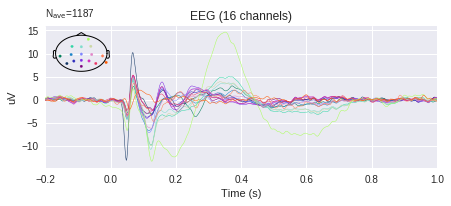

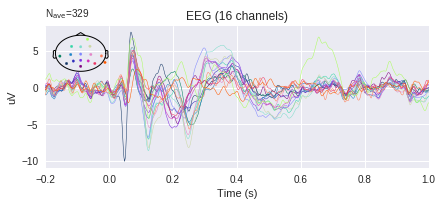

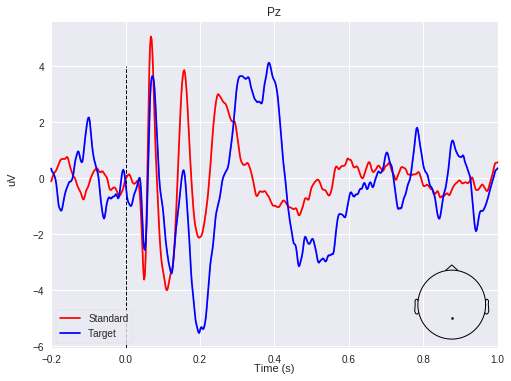

In [107]:
##Preprocessing Settings
event_names = ['Standard','Target']
event_nums = [1,2] # 1 Standard, 2 Target, 9 Response
event_id = {event_names[0]: event_nums[0], event_names[1]: event_nums[1]} #create dict

#keep epoch_decim=1 if using frequency_domain

epochs = preprocess(raw, event_id, event_names, plot_psd=False, filter_data=True, 
               eeg_filter_highpass=1, plot_events=False, epoch_time=(-.2,1), 
               baseline=(-.2,0), rej_thresh_uV=200,
               epoch_decim=1, plot_electrodes=True,
               plot_erp=True)


#Run FeatureEngineer

In [108]:
x_train, x_test, x_val, y_train, y_test, y_val, input_shape, num_classes = FeatureEngineer( epochs,
                    frequency_domain=0, 
                    normalization=True,
                    wavelet_decim=1,flims=(2,30),
                    f_bins=20,wave_cycles=3,
                    spect_baseline=[-1,-.5],
                    electrodes_out= [13,14,15],
                    #electrodes_out= pick_types(epochs.info, meg=False, eeg=True, eog=False),
                    random_seed=1017,model_type = 'NN')


Constructing Time Domain Features
Normalizing X
Combined X Shape: (1516, 500, 16)
Combined Y Shape: (1516,)
Y Example (should be 1s & 0s): [0 0 0 0 0 0 1 1 0 0]
X Range: -10.911286:12.18381
Input Shape: (500, 16)
x_train shape: (909, 500, 16)
909 train samples
304 test samples
303 validation samples


# Run CreateModel

In [114]:
model = CreateModel(input_shape,num_classes, 
                    model_type='NN', batch_size = 16)

Creating NN Model


#Run TrainTestVal

Training Model:
Train on 909 samples, validate on 303 samples
Epoch 1/20
909/909 [==============================] - 2s 3ms/step - loss: 0.7387 - acc: 0.5941 - val_loss: 0.5654 - val_acc: 0.7624
Epoch 2/20
909/909 [==============================] - 1s 610us/step - loss: 0.5961 - acc: 0.7569 - val_loss: 0.5451 - val_acc: 0.7624
Epoch 3/20
909/909 [==============================] - 1s 605us/step - loss: 0.5682 - acc: 0.7558 - val_loss: 0.5343 - val_acc: 0.7624
Epoch 4/20
909/909 [==============================] - 1s 615us/step - loss: 0.5197 - acc: 0.7646 - val_loss: 0.5072 - val_acc: 0.7624
Epoch 5/20
909/909 [==============================] - 1s 613us/step - loss: 0.5120 - acc: 0.7778 - val_loss: 0.4916 - val_acc: 0.7624
Epoch 6/20
909/909 [==============================] - 1s 596us/step - loss: 0.4995 - acc: 0.7690 - val_loss: 0.4952 - val_acc: 0.7624
Epoch 7/20
909/909 [==============================] - 1s 614us/step - loss: 0.4421 - acc: 0.7723 - val_loss: 0.4829 - val_acc: 0.7624
Ep

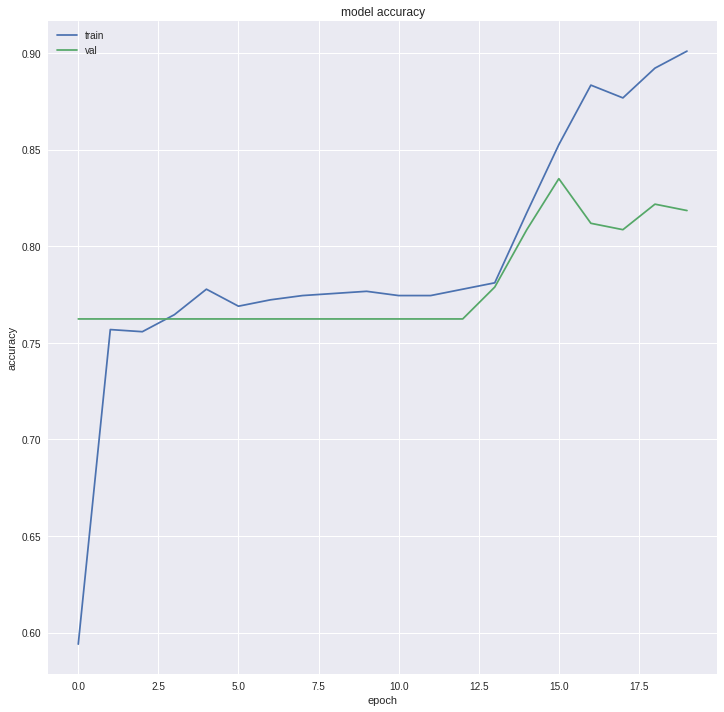

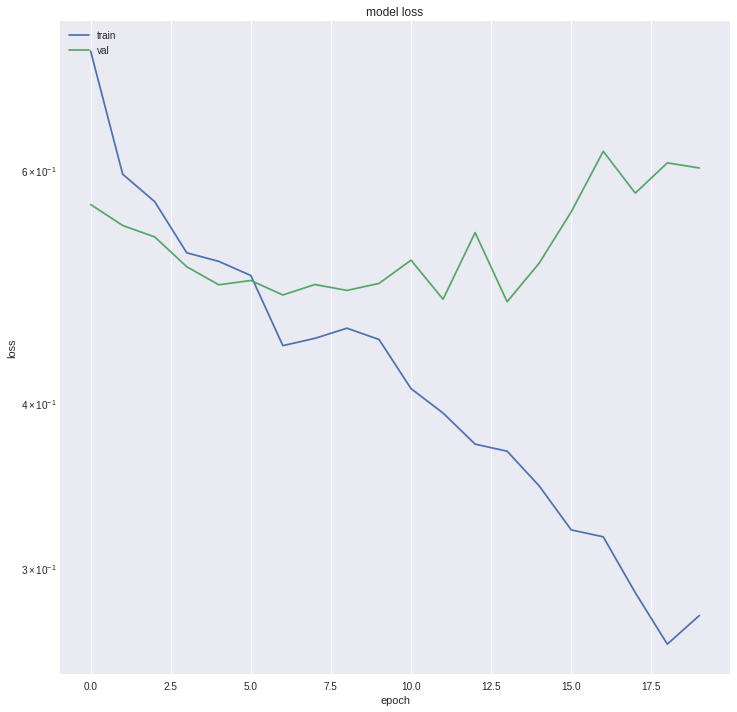

304/304 [==============================] - 0s 210us/step
['loss', 'acc']
Test loss: 0.48432641907742147
Test accuracy: 0.8289473684210527


In [115]:
traintestval(model,
             x_train,x_test,x_val,
             y_train,y_test,y_val,
             batch_size=16,train_epochs=20)
